#Facial Emotions Detection Application (2/3)
For this application of detecting emotions, the target variable is emotion expressed by the facial image, where 1,2,3,4 represents angry, happy, sad, and neutral respectively.

## 1. Environment Setup

In [ ]:
import re   
import numpy as np 
import os
import tarfile
import tensorflow as tf
from random import randint
from glob import glob
import pandas as pd
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model

## 2. Loading Dataset

In [ ]:
!wget https://github.com/alicekejialiu/datasets/raw/main/faces_4.tar.gz

--2022-04-28 23:09:26--  https://github.com/alicekejialiu/datasets/raw/main/faces_4.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alicekejialiu/datasets/main/faces_4.tar.gz [following]
--2022-04-28 23:09:26--  https://raw.githubusercontent.com/alicekejialiu/datasets/main/faces_4.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414060 (404K) [application/octet-stream]
Saving to: ‘faces_4.tar.gz’

faces_4.tar.gz      100%[===================>] 404.36K  --.-KB/s    in 0.02s   

2022-04-28 23:09:27 (17.9 MB/s) - ‘faces_4.tar.gz’ saved [414060/414060]



In [ ]:
tar = tarfile.open('/content/faces_4.tar.gz', "r:gz")
tar.extractall()
tar.close()

## 3. Set Paths for Images

### 3.1 Create two lists to contain imagepaths and emotions

In [ ]:
dataset_path = '/content/faces_4'
imagepaths, emotions = list(), list()

# List the directory
try:
  classes = sorted(os.walk(dataset_path).next()[1])
except Exception:  
  classes = sorted(os.walk(dataset_path).__next__()[1])
        # List each sub-directory (the classes)

for c in classes:
  c_dir = os.path.join(dataset_path, c)
  try:
    walk = os.walk(c_dir).next()
  except Exception: 
    walk = os.walk(c_dir).__next__()
    # Add each image to the training set

  for sample in walk[2]:
    if sample.endswith('.pgm'):
      imagepaths.append(os.path.join(c_dir, sample))

      emotion = sample.split('_')[2]
      if emotion=='angry':
        emotions.append(np.array([(1)]))
      elif emotion=='happy':
        emotions.append(np.array([(2)]))
      elif emotion=='sad':
        emotions.append(np.array([(3)]))
      elif emotion=='neutral':
        emotions.append(np.array([(4)]))

### 3.2 Imagepaths and emotions in DataFrame format

In [ ]:
haha = pd.DataFrame([imagepaths,emotions]).transpose()
haha=haha.rename(columns={0:'imagepaths',1:'emotions'})
haha

,imagepaths,emotions
0,/content/faces_4/an2i/an2i_straight_sad_sungla...,[3]
1,/content/faces_4/an2i/an2i_straight_happy_sung...,[2]
2,/content/faces_4/an2i/an2i_up_angry_sunglasses...,[1]
3,/content/faces_4/an2i/an2i_up_neutral_open_4.pgm,[4]
4,/content/faces_4/an2i/an2i_right_neutral_open_...,[4]
...,...,...
619,/content/faces_4/tammo/tammo_left_neutral_sung...,[4]
620,/content/faces_4/tammo/tammo_straight_neutral_...,[4]
621,/content/faces_4/tammo/tammo_right_angry_open_...,[1]
622,/content/faces_4/tammo/tammo_left_sad_open_4.pgm,[3]


## 4. Create Dataset

### 4.1 Define function for reading pgm files to numpy ndarrays.

In [ ]:
def read_pgm(filename, byteorder='>'):     # '>' indicates big-endian
 
  """Return image data from a raw PGM file as a numpy array.
  Format specification: http://netpbm.sourceforge.net/doc/pgm.html
  """

  with open(filename, 'rb') as f:
    buffer = f.read()
  try:
    header, width, height, maxval = re.search(  
    b"(^P5\s(?:\s*#.*[\r\n])*"             # A pgm image's magic number is the two characters "P5"
    b"(\d+)\s(?:\s*#.*[\r\n])*"             # A width, formatted as ASCII characters in decimal
    b"(\d+)\s(?:\s*#.*[\r\n])*"             # A height, again in ASCII decimal
    b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()  # The maximum gray value (Maxval), again in ASCII decimal. 
                               # Must be less than 65536, and more than zero.
  except AttributeError:
    raise ValueError("Not a raw PGM file: '%s'" % filename)
    
  return np.frombuffer(buffer,
               dtype='u1' if int(maxval) < 256 else byteorder+'u2',
               count=int(width)*int(height),
               offset=len(header)
              ).reshape((int(height)*int(width)))

### 4.2 Read pgm files with image paths

In [ ]:
image = []
for i in range(len(imagepaths)):
  try:
    val = read_pgm(imagepaths[i])
    image.append(val)
  except ValueError:
    image.append(i)

### 4.3 Drop images that cannot be fit into buffer size

In [ ]:
count = 0
fail = []
for i in image:
  if type(i) != np.ndarray:
    fail.append(i)
    count += 1
fail

[11, 19, 88, 197, 269, 274, 380, 449, 480, 487, 489, 497]

### 4.4 Convert data to float32 type

In [ ]:
for i in range(len(image)):
  try:
    val = image[i].reshape(32,30).astype(np.float32)
    image[i] = val
  except AttributeError:
    continue

### 4.5 Create final DataFrame

In [ ]:
wow = pd.DataFrame([image,emotions]).transpose()
wow = wow.rename(columns={0:'image',1:'emotions'})
wow = wow.drop(fail).reset_index().drop(columns='index')
wow = wow.sample(n=wow.shape[0]).reset_index().drop(columns='index')
wow

,image,emotions
0,"[[18.0, 14.0, 16.0, 29.0, 28.0, 27.0, 26.0, 25...",[1]
1,"[[40.0, 37.0, 34.0, 32.0, 29.0, 27.0, 24.0, 22...",[1]
2,"[[21.0, 29.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24...",[3]
3,"[[42.0, 39.0, 38.0, 36.0, 33.0, 31.0, 29.0, 28...",[3]
4,"[[36.0, 33.0, 30.0, 27.0, 25.0, 23.0, 21.0, 19...",[2]
...,...,...
607,"[[49.0, 46.0, 42.0, 39.0, 36.0, 33.0, 31.0, 28...",[4]
608,"[[34.0, 32.0, 30.0, 29.0, 27.0, 25.0, 23.0, 22...",[3]
609,"[[40.0, 41.0, 43.0, 44.0, 46.0, 47.0, 48.0, 48...",[3]
610,"[[36.0, 38.0, 39.0, 41.0, 42.0, 43.0, 44.0, 44...",[1]


## 5. Train Test split

In [ ]:
image2 = list(wow['image'])
emotions2 = list(wow['emotions'])
xs = np.zeros((612,32,30))
ys = np.zeros((612,4))

for i in range(612):
  xs[i] = image2[i]
  ys[i] = emotions2[i]

In [ ]:
X_train, y_train = xs[:400], ys[:400]
X_test, y_test = xs[400:], ys[400:]

## 6. Building AlexNet Model

In [ ]:
inputs = Input(shape=(32,30,1)) # changing input shape to (32,32,3)
h1 = Conv2D(filters=96, kernel_size=(4,4), strides=(2,2), activation='relu')(inputs) # kernel resized to (5,5)
h2 = BatchNormalization()(h1)
h3 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(h2) # changing pool size from (3,3) to (2,2)
h4 = Conv2D(filters=256, kernel_size=(6,6), strides=(1,1), activation='relu', padding="same")(h3) # kernel resized to (3,3)
h5 = BatchNormalization()(h4)
h6 = MaxPooling2D(pool_size=(1,1),strides=(2,2))(h5) # changing pool size from (3,3) to (1,1)
h7 = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(h6) # kernel resized
h8 = BatchNormalization()(h7)
h9 = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(h8) # kernel resized
h10 = BatchNormalization()(h9)
h11 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(h10) # kernel resized
h12 = BatchNormalization()(h11)
h13 = Flatten()(h3)
h14 = Dense(4096, activation='relu')(h13)
h15 = Dropout(0.5)(h14)
h16 = Dense(4096, activation='relu')(h13)
h17 = Dropout(0.5)(h16)
outputs = Dense(4, activation='softmax')(h17)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 30, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 15, 14, 96)        1632      
                                                                 
 batch_normalization (BatchN  (None, 15, 14, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 96)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4704)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              192716

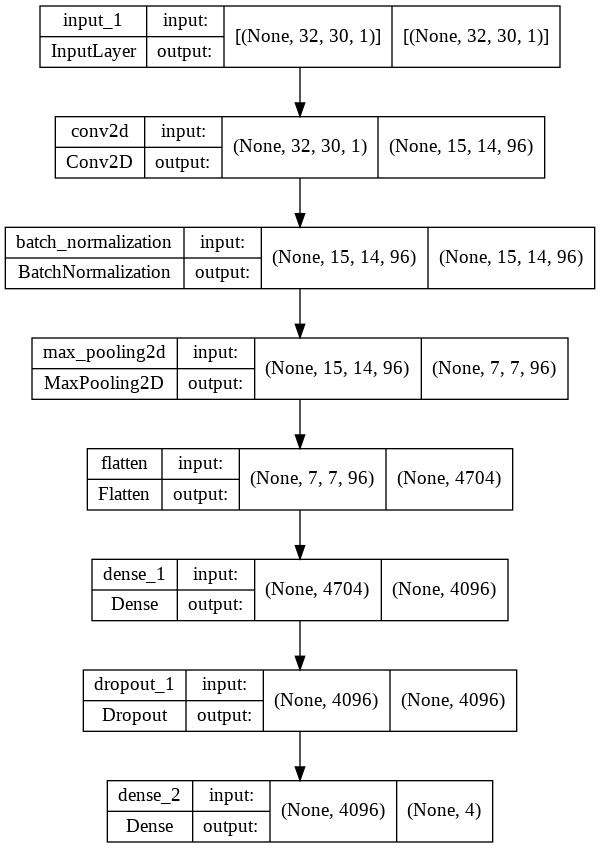

In [ ]:
keras.utils.plot_model(model, "test.png", show_shapes=True)

## 7. Modeling Result

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.01), metrics=['accuracy'])
history = model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/3
13/13 [==============================] - 8s 494ms/step - loss: nan - accuracy: 0.6325 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/3
13/13 [==============================] - 4s 285ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/3
13/13 [==============================] - 3s 264ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000


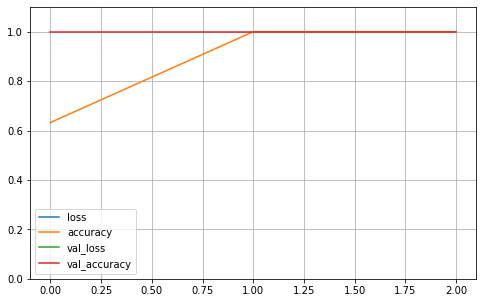

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.1)
plt.show()

## 8. Self-built Model

In [ ]:
input_shape = (32,30,1)
batch_size = 50
kernel_size = 3
filters = 64
dropout = 0.3
num_labels = 4

In [ ]:
# utiliaing functional API to build cnn layers
inputs = Input(shape=input_shape)
h1 = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu',kernel_initializer='he_normal')(inputs)
h2 = MaxPooling2D()(h1)
h3 = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu',kernel_initializer='he_normal')(h2)
h4 = MaxPooling2D()(h3)
h5 = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu',kernel_initializer='he_normal')(h4)
# convert image to vector 
h6 = Flatten()(h5)
# dropout regularization
h7 = Dropout(dropout)(h6)
outputs = Dense(num_labels, activation='softmax')(h7)
# model building by supplying inputs/outputs
model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.SGD(lr=0.01),metrics=['accuracy'])
history = model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=3,batch_size=batch_size)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 2s 163ms/step - loss: nan - accuracy: 0.7200 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/3
8/8 [==============================] - 1s 127ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/3
8/8 [==============================] - 1s 126ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
